In [1]:
from IPython.display import clear_output
from tqdm import tqdm
import time
import numpy as np

In [2]:
#from slac_discrete.learn import get_sequence, calc_latent_loss, update_params, optimizer, get_feature_seq
from slac_discrete.learn import get_sequence, update_params, calc_kl_divergence
#from slac_discrete.model import SACNet
from env_wrapper import create_env

In [3]:
import torch
from omegaconf import OmegaConf

flags = OmegaConf.create({
    #"env": "BreakoutNoFrameskip-v4",
    "env": "PongNoFrameskip-v4",
    "model": "Random", # Vanilla or SAC or SLAC
    "ObsType": "Atari", # Atari or State or Image
    "State2Image": True,
    "num_stack": 1,
    "ActionType": "Discrete", # Continuous or Discrete
    "action_shape":None,
    "observation_shape": None,

    "cuda": True,
    "device": "cuda" ,

    "num_sequences": 8,
    
    "batch_size": 8,
    "unroll_length": 40,

    "use_lstm": False,

    "entropy_cost": 0.01,
    "baseline_cost": 0.5,
    "discounting": 0.99,
    "multi_step": 1,
    "reward_clipping": "abs_one",

    "learning_rate": 0.0004,
    "latent_learning_rate": 0.0001,
    "alpha": 0.99,
    "momentum": 0,
    "epsilon": 0.01,
    "grad_norm_clipping": 40.0,
})

flags.device = None
if flags.cuda and torch.cuda.is_available():
    print("Using CUDA.")
    flags.device = str(torch.device("cuda"))
else:
    print("Not using CUDA.")
    flags.device = str(torch.device("cpu"))

env = create_env(flags)

flags.action_shape = env.action_space.n
flags.observation_shape = tuple(env.observation_space.shape)

env.close()

Using CUDA.


----------------Make Model----------------------

In [4]:
import torch
import torch.nn as nn
from torch.distributions import Normal
from torch.nn import functional as F
from torch.optim import Adam

from slac_discrete.model import weights_init_xavier, create_linear_network, Gaussian, ConstantGaussian


In [5]:
class Decoder(nn.Module):

    def __init__(self, input_dim=288, output_dim=3, std=1.0, leaky_slope=0.2):
        super(Decoder, self).__init__()
        self.std = std

        self.net = nn.Sequential(
            # (32+256, 1, 1) -> (256, 4, 4)
            nn.ConvTranspose2d(input_dim, input_dim, 3),
            nn.LeakyReLU(leaky_slope),
            # (32+256, 4, 4) -> (256, 12, 12)
            nn.ConvTranspose2d(input_dim, 256, 3, 2, 1, 1),
            nn.LeakyReLU(leaky_slope),
            # (256, 12, 12) -> (128, 21, 21)
            nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),
            nn.LeakyReLU(leaky_slope),
            # (128, 8, 8) -> (64, 16, 16)
            nn.ConvTranspose2d(128, 64, 3, 2, 2),
            nn.LeakyReLU(leaky_slope),
            # (64, 16, 16) -> (32, 32, 32)
            nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
            nn.LeakyReLU(leaky_slope),
            # (32, 32, 32) -> (3, 64, 64)
            nn.ConvTranspose2d(32, output_dim, 5, 2, 2, 1),
            nn.LeakyReLU(leaky_slope)
        ).apply(weights_init_xavier)

    def forward(self, x):
        if isinstance(x, list) or isinstance(x, tuple):
            x = torch.cat(x,  dim=-1)

        num_batches, num_sequences, latent_dim = x.size()
        x = x.view(num_batches * num_sequences, latent_dim, 1, 1)
        x = self.net(x)
        _, C, W, H = x.size()
        x = x.view(num_batches, num_sequences, C, W, H)
        return Normal(loc=x, scale=torch.ones_like(x) * self.std)
        # return {"loc":x, "scale":torch.ones_like(x) * self.std}
    
class Encoder(nn.Module):

    def __init__(self, input_dim=3, output_dim=256, leaky_slope=0.2):
        super(Encoder, self).__init__()
       
        self.net = nn.Sequential(
            # (3, 84, 84) -> (32, 42, 42)
            nn.Conv2d(input_dim, 32, 5, 2, 2),
            nn.LeakyReLU(leaky_slope),
            # (32, 42, 42) -> (64, 21, 21)
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.LeakyReLU(leaky_slope),
            # (64, 21, 21) -> (128, 24, 24)
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.LeakyReLU(leaky_slope),
            # (128, 24, 24) -> (256, 12, 12)
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.LeakyReLU(leaky_slope),
            # (256, 12, 12) -> (256, 3, 3)
            nn.Conv2d(256, output_dim, 3),
            nn.LeakyReLU(leaky_slope),
            # (256, 3, 3) -> (256, 1, 1)
            nn.Conv2d(256, output_dim, 4),
            nn.LeakyReLU(leaky_slope),
        ).apply(weights_init_xavier)

    def forward(self, x):
        num_batches, num_sequences, C, H, W = x.size()
        x = x.view(num_batches * num_sequences, C, H, W)
        x = self.net(x)
        x = x.view(num_batches, num_sequences, -1)

        return x

In [6]:

class LatentNetwork(nn.Module):

    def __init__(self, observation_shape, action_shape, feature_dim=256,
                 latent1_dim=32, latent2_dim=256, hidden_units=[256, 256],
                 leaky_slope=0.2):
        super(LatentNetwork, self).__init__()
        # NOTE: We encode x as the feature vector to share convolutional
        # part of the network with the policy.

        # p(z1(0)) = N(0, I)
        self.latent1_init_prior = ConstantGaussian(latent1_dim)
        # p(z2(0) | z1(0))
        self.latent2_init_prior = Gaussian(
            latent1_dim, latent2_dim, hidden_units, leaky_slope=leaky_slope)
        # p(z1(t+1) | z2(t), a(t))
        self.latent1_prior = Gaussian(
            latent2_dim + action_shape[0], latent1_dim, hidden_units,
            leaky_slope=leaky_slope)
        # p(z2(t+1) | z1(t+1), z2(t), a(t))
        self.latent2_prior = Gaussian(
            latent1_dim + latent2_dim + action_shape[0], latent2_dim,
            hidden_units, leaky_slope=leaky_slope)

        
        # q(z1(0) | feat(0))
        self.latent1_init_posterior = Gaussian(
            feature_dim, latent1_dim, hidden_units, leaky_slope=leaky_slope)
        # q(z2(0) | z1(0)) = p(z2(0) | z1(0))
        self.latent2_init_posterior = self.latent2_init_prior
        # q(z1(t+1) | feat(t+1), z2(t), a(t))
        self.latent1_posterior = Gaussian(
            feature_dim + latent2_dim + action_shape[0], latent1_dim,
            hidden_units, leaky_slope=leaky_slope)
        # q(z2(t+1) | z1(t+1), z2(t), a(t)) = p(z2(t+1) | z1(t+1), z2(t), a(t))
        self.latent2_posterior = self.latent2_prior

        # p(r(t) | z1(t), z2(t), a(t), z1(t+1), z2(t+1))
        self.reward_predictor = Gaussian(
            2 * latent1_dim + 2 * latent2_dim + action_shape[0],
            1, hidden_units, leaky_slope=leaky_slope)

        # feat(t) = x(t) : This encoding is performed deterministically.
        self.encoder = Encoder(
            observation_shape[0], feature_dim, leaky_slope=leaky_slope)
        # p(x(t) | z1(t), z2(t))
        self.decoder = Decoder(
            latent1_dim + latent2_dim, observation_shape[0],
            std=np.sqrt(0.1), leaky_slope=leaky_slope)

    def sample_prior(self, actions_seq, init_features=None):
        ''' Sample from prior dynamics (with conditionning on the initial frames).
        Args:
            actions_seq   : (N, S, *action_shape) tensor of action sequences.
            init_features : (N, *) tensor of initial frames or None.
        Returns:
            latent1_samples : (N, S+1, L1) tensor of sampled latent vectors.
            latent2_samples : (N, S+1, L2) tensor of sampled latent vectors.
            latent1_dists   : (S+1) length list of (N, L1) distributions.
            latent2_dists   : (S+1) length list of (N, L2) distributions.
        '''
        num_sequences = actions_seq.size(1)
        actions_seq = torch.transpose(actions_seq, 0, 1)

        latent1_samples = []
        latent2_samples = []
        latent1_dists = []
        latent2_dists = []

        for t in range(num_sequences + 1):
            if t == 0:
                # Condition on initial frames.
                if init_features is not None:
                    # q(z1(0) | feat(0))
                    latent1_dist = self.latent1_init_posterior(init_features)
                    latent1_sample = latent1_dist.rsample()
                    # q(z2(0) | z1(0))
                    latent2_dist = self.latent2_init_posterior(latent1_sample)
                    latent2_sample = latent2_dist.rsample()

                # Not conditionning.
                else:
                    # p(z1(0)) = N(0, I)
                    latent1_dist = self.latent1_init_prior(actions_seq[t])
                    latent1_sample = latent1_dist.rsample()
                    # p(z2(0) | z1(0))
                    latent2_dist = self.latent2_init_prior(latent1_sample)
                    latent2_sample = latent2_dist.rsample()

            else:
                # p(z1(t) | z2(t-1), a(t-1))
                latent1_dist = self.latent1_prior(
                    [latent2_samples[t-1], actions_seq[t-1]])
                latent1_sample = latent1_dist.rsample()
                # p(z2(t) | z1(t), z2(t-1), a(t-1))
                latent2_dist = self.latent2_prior(
                    [latent1_sample, latent2_samples[t-1], actions_seq[t-1]])
                latent2_sample = latent2_dist.rsample()

            latent1_samples.append(latent1_sample)
            latent2_samples.append(latent2_sample)
            latent1_dists.append(latent1_dist)
            latent2_dists.append(latent2_dist)

        latent1_samples = torch.stack(latent1_samples, dim=1)
        latent2_samples = torch.stack(latent2_samples, dim=1)

        return (latent1_samples, latent2_samples),\
            (latent1_dists, latent2_dists)

    def sample_posterior(self, features_seq, actions_seq):
        ''' Sample from posterior dynamics.
        Args:
            features_seq : (N, S+1, 256) tensor of feature sequenses.
            actions_seq  : (N, S, *action_space) tensor of action sequenses.
        Returns:
            latent1_samples : (N, S+1, L1) tensor of sampled latent vectors.
            latent2_samples : (N, S+1, L2) tensor of sampled latent vectors.
            latent1_dists   : (S+1) length list of (N, L1) distributions.
            latent2_dists   : (S+1) length list of (N, L2) distributions.
        '''
        num_sequences = actions_seq.size(1)
        features_seq = torch.transpose(features_seq, 0, 1)
        actions_seq = torch.transpose(actions_seq, 0, 1)

        latent1_samples = []
        latent2_samples = []
        latent1_dists = []
        latent2_dists = []

        for t in range(num_sequences + 1):
            if t == 0:
                # q(z1(0) | feat(0))
                latent1_dist = self.latent1_init_posterior(features_seq[t])
                latent1_sample = latent1_dist.rsample()
                # q(z2(0) | z1(0))
                latent2_dist = self.latent2_init_posterior(latent1_sample)
                latent2_sample = latent2_dist.rsample()
            else:
                # q(z1(t) | feat(t), z2(t-1), a(t-1))
                latent1_dist = self.latent1_posterior(
                    [features_seq[t], latent2_samples[t-1], actions_seq[t-1]])
                latent1_sample = latent1_dist.rsample()
                # q(z2(t) | z1(t), z2(t-1), a(t-1))
                latent2_dist = self.latent2_posterior(
                    [latent1_sample, latent2_samples[t-1], actions_seq[t-1]])
                latent2_sample = latent2_dist.rsample()

            latent1_samples.append(latent1_sample)
            latent2_samples.append(latent2_sample)
            latent1_dists.append(latent1_dist)
            latent2_dists.append(latent2_dist)

        latent1_samples = torch.stack(latent1_samples, dim=1)
        latent2_samples = torch.stack(latent2_samples, dim=1)

        return (latent1_samples, latent2_samples),\
            (latent1_dists, latent2_dists)


Learn

In [7]:
def calc_latent_loss(flags, model, images_seq, actions_seq, rewards_seq, dones_seq, images):
    features_seq = get_feature_seq(flags, model, images)
    
    # Sample from posterior dynamics.
    (latent1_post_samples, latent2_post_samples),\
        (latent1_post_dists, latent2_post_dists) =\
        model.sample_posterior(features_seq, actions_seq)
    # Sample from prior dynamics.
    (latent1_pri_samples, latent2_pri_samples),\
        (latent1_pri_dists, latent2_pri_dists) =\
        model.sample_prior(actions_seq)

    # KL divergence loss.
    kld_loss = calc_kl_divergence(latent1_post_dists, latent1_pri_dists)

    # Log likelihood loss of generated observations.
    images_seq_dists = model.decoder(
        [latent1_post_samples, latent2_post_samples])
    
    log_likelihood_loss = images_seq_dists.log_prob(
        images_seq).mean(dim=0).sum()
    
    # Log likelihood loss of genarated rewards.
    rewards_seq_dists = model.reward_predictor([
        latent1_post_samples[:, :-1],
        latent2_post_samples[:, :-1],
        actions_seq, latent1_post_samples[:, 1:],
        latent2_post_samples[:, 1:]])
    reward_log_likelihoods =\
        rewards_seq_dists.log_prob(rewards_seq) * (1.0 - dones_seq)
    reward_log_likelihood_loss = reward_log_likelihoods.mean(dim=0).sum()

    latent_loss =\
        kld_loss - log_likelihood_loss - reward_log_likelihood_loss

    return latent_loss, kld_loss, log_likelihood_loss, reward_log_likelihood_loss

def get_feature_seq(flags, model, images):
    
    features = model.encoder(images)

    batch_size_1 = flags.unroll_length + 1  - flags.num_sequences
    batch_size_2 = flags.batch_size

    features_seq = torch.Tensor(np.empty((
        batch_size_1, batch_size_2, flags.num_sequences+1, 256),
        dtype=np.uint8)).to(flags.device)

    for i_1 in range(batch_size_1):
        for i_2 in range(batch_size_2):
            features_seq[i_1, i_2, ...]  = features[i_1:i_1+flags.num_sequences+1, i_2]

    num_batches, num, num_sequences, C = features_seq.size()
    features_seq = features_seq.view(num_batches * num, num_sequences, C)
    return features_seq


In [8]:
def learn(flags, learner_model, batch, optim):
    images_seq, actions_one_hot_seq, actions, rewards_seq, dones_seq, rewards, images = get_sequence(flags, batch)

    latent_loss, kld_loss, log_likelihood_loss, reward_log_likelihood_loss = calc_latent_loss(
        flags, learner_model, images_seq, actions_one_hot_seq, rewards_seq, dones_seq, images)


    update_params(
        optim, learner_model, latent_loss, flags.grad_norm_clipping)
    
    return latent_loss, kld_loss, log_likelihood_loss, reward_log_likelihood_loss
    
    

In [9]:

T = flags.unroll_length
B = flags.batch_size

feature_dim = 256
latent1_dim = 32
latent2_dim = 256
hidden_units = [256, 256]
leaky_slope = 0.2
model = LatentNetwork(
            flags.observation_shape, [flags.action_shape], feature_dim,
            latent1_dim, latent2_dim, hidden_units, leaky_slope
            ).to(flags.device)


optim = Adam(model.parameters(), lr=flags.latent_learning_rate)

In [10]:
import pickle
import os
folder_name = "./logs"
file_names = os.listdir(folder_name)
file_names = [file_name  for file_name in file_names if ".pickle" in file_name]

batches = []
for i in (range(len(file_names))):
    file_name = folder_name + "/" + file_names[i]
    with open(file_name, 'rb') as f:
        batch = pickle.load(f)
    batches.append(batch)

In [11]:
step = 0
start_time = time.time()
all_step = T * B * len(file_names)
for t in range(2):
    for i in (range(len(file_names))):
        batch = batches[i]
        latent_loss, kld_loss, log_likelihood_loss, reward_log_likelihood_loss = learn(flags, model, batch, optim)

        step += T * B
        sps = step/(time.time()-start_time)
        rt_m = int((all_step - step) / sps / 60)
        rt_s = int((all_step - step) / sps %60)
        print("latent_loss : " + str(latent_loss.item()) + "\n" +
              "kld_loss : " + str(kld_loss.item()) + "\n" +
              "log_likelihood_losslikelihood_loss : " + str(log_likelihood_loss.item()) + "\n" +
              "reward_log_likelihood_loss : " + str(reward_log_likelihood_loss.item()) + "\n" +
              "total step : " + str(step) + "/" + str(all_step) + "\n" +
              "sps : " + str(sps) + "\n" +
              "retain time : " + str( rt_m ) + " m " + str( rt_s ) + " s"
             ) 
        clear_output(True)


latent_loss : -43431.8203125
kld_loss : 78.25859832763672
log_likelihood_losslikelihood_loss : 43506.8046875
reward_log_likelihood_loss : 3.273911952972412
total step : 200320/100160
sps : 372.6374201161528
retain time : -4 m 31 s



---------------Plot Images---------------

In [12]:
images_seq, actions_one_hot_seq, actions, rewards_seq, dones_seq, rewards, images = get_sequence(flags, batch)
features_seq = get_feature_seq(flags, model, images)
(latent1_post_samples, latent2_post_samples),\
        (latent1_post_dists, latent2_post_dists) =\
        model.sample_posterior(features_seq, actions_one_hot_seq)

images_seq_dists = model.decoder(
        [latent1_post_samples, latent2_post_samples])

In [17]:
from __future__ import print_function
import torchvision
import matplotlib.pyplot as plt
import numpy as np
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(npimg)
    plt.show()
def get_recon_image(model, images, actions):
    features = model.encoder(images)
    (latent1_post_samples, latent2_post_samples),\
        (latent1_post_dists, latent2_post_dists) =\
        model.sample_posterior(features, actions)

    images_seq_dists = model.decoder(
            [latent1_post_samples, latent2_post_samples])
    return images_seq_dists

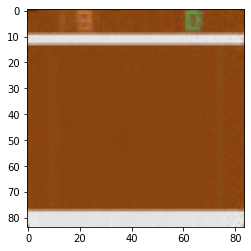

In [18]:
img = images_seq_dists.mean[-1,-1].detach().cpu()
#img = images_seq_dists.sample().cpu()
img = np.clip(img, 0, 1)
img = (img*255).int()
imshow(img)

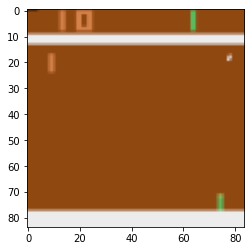

In [19]:
img = images_seq[-1,-1].cpu()
img = np.clip(img, 0, 1)
img = (img*255).int()
imshow(img)

In [20]:
gym_env = create_env(flags)
from core import environment
env = environment.Environment(gym_env)

In [50]:
from collections import deque

def reset_deque(states):
    state_deque = deque(maxlen=flags.num_sequences)
    action_deque = deque(maxlen=flags.num_sequences-1)

    for _ in range(flags.num_sequences-1):
        state_deque.append(
            np.zeros(flags.observation_shape, dtype=np.uint8))
        action_deque.append(
            np.zeros((flags.action_shape), dtype=np.uint8))
    state_deque.append(states)
    return state_deque, action_deque

In [51]:
flags.observation_shape
env_output["frame"].squeeze(0).squeeze(0).numpy().shape

(3, 84, 84)

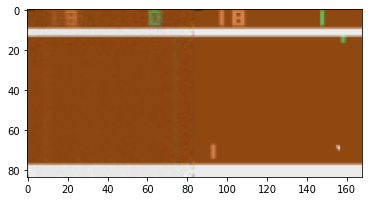

In [93]:
env_output = env.initial()

state_deque, action_deque = reset_deque(env_output["frame"].squeeze(0).squeeze(0).numpy())

for i in range(50):
    action = torch.Tensor([np.random.randint(flags.action_shape)]).int().view(1,1)
    env_output = env.step(action)
    
    state_q = torch.Tensor(np.array(state_deque, dtype=np.float32)).unsqueeze(0).to(flags.device).float() / 255.0
    action_q = torch.FloatTensor(np.array(action_deque, dtype=np.float32)).to(flags.device).unsqueeze(0)
    dists = get_recon_image(model, state_q, action_q)
    
    state_deque.append(torch.ByteTensor(env_output["frame"]).squeeze(0).squeeze(0).numpy())
    action_one_hot = np.eye(flags.action_shape)[action]
    action_deque.append(action_one_hot)
    
    
    #img = dists.sample()[0,0].cpu()
    img = dists.mean[-1,-1].detach().cpu()
    img = np.clip(img, 0, 1)
    img = (img*255).int()
    img_obs = env_output["frame"][0,0].cpu().int()
    img = torch.cat((img, img_obs),2)
    imshow(img)
    clear_output(True)

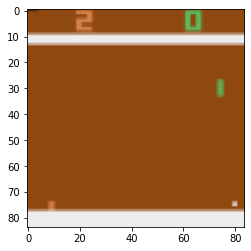

In [30]:
env_output = env.initial()

for i in range(10):
    action = torch.Tensor([np.random.randint(flags.action_shape)]).int().view(1,1)
    env_output = env.step(action)
    img = env_output["frame"][0,0].cpu()
    #img = np.clip(img, 0, 1)
    #img = (img*255).int()
    imshow(img)
    clear_output(True)